In [ ]:
%pip install tweepy
%pip install wordsegment
%pip install autocorrect
%pip install spacy
%pip install gensim
%pip install vaderSentiment
%pip install textblob
%pip install wordcloud
%pip install MySQL-python
%pip install mysql-connector-python
%pip install pymysql
%pip install GetOldTweets3
%pip install Pillow

In [755]:
import os
import tweepy
import json
from sqlalchemy import create_engine
import pymysql
import pickle
import numpy as np
import GetOldTweets3 as got
import pandas as pd
import nltk
nltk.download('wordnet')
import re
import nltk
import string
import wordsegment 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import MWETokenizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from gensim import corpora, models, similarities, matutils
import logging
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#setting up a mysql server and connecting to it

import mysql.connector
mydb = mysql.connector.connect(
  host="35.235.70.118",
  user="",
  passwd="",
  database="tweets"
)



In [ ]:
#creating a table in mysql to write our tweets into

mycursor = mydb.cursor()
mycursor.execute("CREATE TABLE tweetstable (user_name VARCHAR(255), text text, time VARCHAR(255) , hashtags varchar(1024))")

In [ ]:
#setting up a twitter streamer feel free to copy the code and repalce it with your own API keys.

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from sqlalchemy.exc import ProgrammingError




# a function that help us write tweets from the stream into sql database
def store_data(id_str, created, text,name,loc,coord):
    
        
        mydb = mysql.connector.connect(
          host="35.235.70.118",
          user="",
          passwd="",
          database="tweets"
        )
        
        mycursor = mydb.cursor()
        sqladd= "INSERT INTO tweetstable (user_id, time, text, user_name, hashtags) VALUES (%s,%s,%s,%s,%s)"
        val = (id_str, created, text,name,hashtags)
        
        mycursor.execute(sqladd, val)
        mydb.commit()
        
        #print(mycursor.rowcount, "record(s) inserted.")
        

        
        
        

# Your credentials go here
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

class StreamListener(StreamListener):
    """ A listener handles tweets that are received from the stream.
    This is a basic listener that just prints received tweets to stdout.
    """
    
    def on_connect(self):
        
        print("You're connected to the streaming server.")
        
        
    def on_status(self, status):
         
       
        id_str = status.id_str
        created = status.created_at
        text = str(status.text)
        name = status.user.screen_name
        loc=status.user.location
        coord=str(status.place)
        
        
        
        if 'USA' in coord:
        
            
            #store_data(id_str, created, text,name,loc,coord)
            print(text,coord)
        
       

    def on_error(self, status_code):
        if status_code == 420:
            return False

if __name__ == '__main__':
    
    stream_listener = StreamListener(api=tweepy.API(wait_on_rate_limit=False))
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    stream = Stream(auth, stream_listener)
    
    stream.filter(track=['andrewyang','yanggang','humanityforward'],languages = ["en"])

In [ ]:

#getOldTweets3 setup for looking at tweets in the past.
tweetCriteria = got.manager.TweetCriteria().setQuerySearch('andrew yang')\
                                           .setSince("2015-01-01")\
                                           .setUntil("2020-08-17")\
                                           .setMaxTweets(10000)\
                                           .setNear('Phoenix,Arizona')\
                                           .setWithin("300km")
                              
tweet = got.manager.TweetManager.getTweets(tweetCriteria)


for tw in tweet:
    store_datav2(tw.date,tw.text,tw.username,tw.hashtags)







In [ ]:
# a second function that help us write tweets from the stream into sql database, for getOldTweets3.

def store_datav2(created, text,name,hashtags):
    
        
        mydb = mysql.connector.connect(
          host="",
          user="",
          passwd="",
          database=""
        )
        
        mycursor = mydb.cursor()
        sqladd= "INSERT INTO tweetstable(user_name,text,time, hashtags) VALUES (%s,%s,%s,%s)"
        val = (name,text,created,hashtags)
        
        mycursor.execute(sqladd, val)
        mydb.commit()

In [ ]:
#getting the fields of data that is needed for analysis.
text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.hashtags,
                ] for tw in tweet]

In [ ]:
#connection to the server

db_connection_str = ''
db_connection = create_engine(db_connection_str)

In [ ]:
#turning sql data to a pandas dataframe for analysis
df = pd.read_sql('SELECT * FROM tweetstable', con=db_connection)
df.columns=['user_name','text','time','hashtags']

df.drop_duplicates(subset=['text'], keep='last',inplace=True)
df=df.reset_index().drop(columns=['index'])

In [ ]:
#df.to_pickle('tweet_data.pkl')
#df= pd.read_pickle('tweet_data.pkl')

In [273]:
#text preproecessor class to prepare it for topic modeling and sentiment analysis

class preprocessor:
    def __init__(self,vectorizer=None,tokenizer=None, cleaning_function=None, 
                 stemmer=None,model=None):
        
        clean_function=self.clean_text
        self.cleaning_function = cleaning_function
        self.stemmer = stemmer
        self.vectorizer = vectorizer
        self._is_fit = False
        
        
    def tokenizer(self, text):
        mwe_tokenizer= MWETokenizer([('andrew','yang'),('yang','gang'),('pete','buttigeg'),('joe','biden'),('kamala','harris'),('humanity','forward'),('donald','trump'),('freedom','dividend')
                                    ,('tulsi','gabbard'),('marianne', 'williamson'),('bernie','sanders'),('elizabeth','warren'),('amy','klobuchar'),('cory','booker'),('joe','rogan'),('elon','musk')
                                    ,('let','yang','speak'),('yang','media','blackout'),('trump','fears','yang'),('make','america','think','harder')])
        wordsegment.load()
        text=mwe_tokenizer.tokenize(wordsegment.segment(text))
        
        return text
    
    def clean_text(self, text):
        spellcheck=Speller()
        cleaned_text = []
        for tweet in text:
            cleaned_words = []
            tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', tweet, flags=re.MULTILINE)
            tweet = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', tweet, flags=re.MULTILINE)
            
            for word in self.tokenizer(tweet):
                low_word=re.sub('\w*\d\w*', ' ', word)
                low_word=spellcheck(low_word)
                low_word = self.stemmer.lemmatize(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
            
        return cleaned_text
    
    def fit_transform(self, text):
        #clean_text = self.clean_text(text)
        
        return self.vectorizer.fit_transform(text)
        
        
    def save_pipe(self, filename):

        pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))
        
    def load_pipe(self, filename):

        self.__dict__ = pickle.load(open("models/vectorizer.pickle", 'rb'))
        


In [815]:
#adding additional stop words to the existing library

add_stop_words=['just','dont','im','hi','ha','thi','wa','yang','andrew_yang','yang_gang','does','thing','andrew','mani','veri','thanks','support','thats'
               'thats','make','duc','time','democratic','going','amp','say','did','way','like','year','doe','right','left','month','think','know','american',
               'idea','good','real','come','got','yes','really','ive','lot','voting','joe_bien','said','sure','titi','work','new','day','great','best','let','don']

stop_words=text.ENGLISH_STOP_WORDS.union(add_stop_words)


In [816]:
nlp=preprocessor(vectorizer=TfidfVectorizer(ngram_range=(1,2),stop_words=stop_words,min_df=0.01,max_df=0.8),stemmer=WordNetLemmatizer())

In [17]:
#cleaned_text=nlp.clean_text(df['text'])
#with open('cleantext.pkl', 'wb') as f:
    #pickle.dump(cleaned_text, f)

In [40]:
#cleaned_text_lemmatized=nlp.clean_text(df['text'])
#with open('cleantextlemmatized.pkl', 'wb') as f:
    #pickle.dump(cleaned_text_lemmatized, f)



In [276]:
cleaned_text_lemmatized=pd.read_pickle('cleantextlemmatized.pkl')

### LDA topic modeling

In [24]:
#LDA topic modeling
doc_word=nlp.fit_transform(cleaned_text_lemmatized).transpose()
corpus = matutils.Sparse2Corpus(doc_word)
id2word = dict((v, k) for k, v in nlp.vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=20);
lda.print_topics()

2020-08-19 18:24:13,662 : INFO : topic #0 (0.200): 0.084*"people" + 0.062*"math" + 0.061*"help" + 0.057*"bien" + 0.056*"low" + 0.055*"believe" + 0.055*"agree" + 0.054*"joe_bien" + 0.052*"better" + 0.047*"warren"
2020-08-19 18:24:13,664 : INFO : topic #1 (0.200): 0.098*"debate" + 0.095*"love" + 0.080*"president" + 0.063*"really" + 0.057*"campaign" + 0.056*"new" + 0.049*"democrat" + 0.044*"problem" + 0.041*"lot" + 0.040*"talking"
2020-08-19 18:24:13,665 : INFO : topic #2 (0.200): 0.074*"great" + 0.063*"day" + 0.060*"life" + 0.057*"election" + 0.056*"man" + 0.050*"said" + 0.050*"plan" + 0.049*"party" + 0.049*"state" + 0.047*"job"
2020-08-19 18:24:13,666 : INFO : topic #3 (0.200): 0.162*"need" + 0.072*"america" + 0.069*"ubi" + 0.057*"ive" + 0.055*"point" + 0.055*"look" + 0.052*"policy" + 0.052*"win" + 0.051*"best" + 0.049*"thank"
2020-08-19 18:24:13,667 : INFO : topic #4 (0.200): 0.092*"money" + 0.077*"trump" + 0.062*"support" + 0.050*"let" + 0.046*"candidate" + 0.046*"government" + 0.041*

[(0,
  '0.084*"people" + 0.062*"math" + 0.061*"help" + 0.057*"bien" + 0.056*"low" + 0.055*"believe" + 0.055*"agree" + 0.054*"joe_bien" + 0.052*"better" + 0.047*"warren"'),
 (1,
  '0.098*"debate" + 0.095*"love" + 0.080*"president" + 0.063*"really" + 0.057*"campaign" + 0.056*"new" + 0.049*"democrat" + 0.044*"problem" + 0.041*"lot" + 0.040*"talking"'),
 (2,
  '0.074*"great" + 0.063*"day" + 0.060*"life" + 0.057*"election" + 0.056*"man" + 0.050*"said" + 0.050*"plan" + 0.049*"party" + 0.049*"state" + 0.047*"job"'),
 (3,
  '0.162*"need" + 0.072*"america" + 0.069*"ubi" + 0.057*"ive" + 0.055*"point" + 0.055*"look" + 0.052*"policy" + 0.052*"win" + 0.051*"best" + 0.049*"thank"'),
 (4,
  '0.092*"money" + 0.077*"trump" + 0.062*"support" + 0.050*"let" + 0.046*"candidate" + 0.046*"government" + 0.041*"people" + 0.041*"doesnt" + 0.040*"tax" + 0.040*"free"')]

### NMF and LSA topic modeling

In [ ]:
doc_word=nlp.fit_transform(cleaned_text_lemmatized)

In [826]:

#nmf topic modeling 
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(doc_word)

In [832]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 8)


Topic  0
people      3.60, job      0.16, life      0.11, ubi      0.10, humanity      0.10, america      0.09, income      0.09, country      0.08

Topic  1
need      2.84, america      0.27, help      0.17, bien      0.16, policy      0.13, state      0.12, win      0.10, government      0.09

Topic  2
vote      2.19, trump      1.95, bien      0.33, election      0.27, jernie      0.24, democrat      0.24, choice      0.22, party      0.20

Topic  3
love      2.68, election      0.10, forward      0.10, math      0.06, hope      0.05, america      0.05, humanity      0.05, party      0.05

Topic  4
debate      2.30, candidate      1.43, dem      0.58, pete      0.32, warren      0.29, campaign      0.22, jernie_sanders      0.21, election      0.15

Topic  5
money      1.69, want      1.38, thats      0.94, president      0.37, pay      0.34, free      0.30, help      0.25, tax      0.23


In [850]:
topics_interpreted=['poverty and UBI','change in Washington','2020 Election','Yang, the visionary','democratic debates','other topics']
topics_listed=[(ind+1,topic) for ind, topic in enumerate(topics_interpreted)]

In [ ]:
def get_score(model, data, scorer=metrics.explained_variance_score):
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)

ks = [1,2,3,4,5,6]
perfs = []

for k in ks:
    nmf = NMF(k).fit(doc_word.toarray())
    perfs.append(get_score(nmf, doc_word.toarray()))
    
print(perfs)

In [420]:
#LSA topic modeling
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.02975416, 0.03036034, 0.02530096, 0.02606937, 0.02300866,
       0.02265915])

In [ ]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = nlp.vectorizer.get_feature_names())
topic_word

In [28]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join(feature_names[i] + ' ' + f'{topic[i]:9.2f}'
                        for i in topic.argsort()[:-no_top_words - 1:-1]))

In [ ]:
display_topics(lsa,  nlp.vectorizer.get_feature_names(), 5)

### Sentiment analysis

In [28]:
CountVec=pd.DataFrame(doc_word.toarray(), index=df['text'], columns=nlp.vectorizer.get_feature_names()).head(10)

In [56]:
cleanedtext_df=pd.DataFrame(cleaned_text_lemmatized,columns=['tweets'])

In [88]:
cleanedtext_df['subjectivity']=cleanedtext_df['tweets'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
cleanedtext_df['polarity']=cleanedtext_df['tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [107]:
df.loc[(df['time']<'2019-11-20')&(df['time']>'2019-09-12')].index

Int64Index([2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456,
            ...
            2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933],
           dtype='int64', length=487)

In [77]:
cleanedtext_df['polarity'][3545]=-0.07499999999999998

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    if score ==0:
        return 'Neutral'
    if score > 0:
        return 'Positive'
    
cleanedtext_df['analysis']=cleanedtext_df['polarity'].apply(getAnalysis)

In [639]:
cleanedtext_df['polarity']

0      -3.700743e-17
1       2.000000e-01
2      -2.500000e-02
3      -5.000000e-02
4       1.142857e-01
            ...     
3580    0.000000e+00
3581    0.000000e+00
3582    4.000000e-01
3583   -1.666667e-01
3584   -3.625000e-01
Name: polarity, Length: 3585, dtype: float64

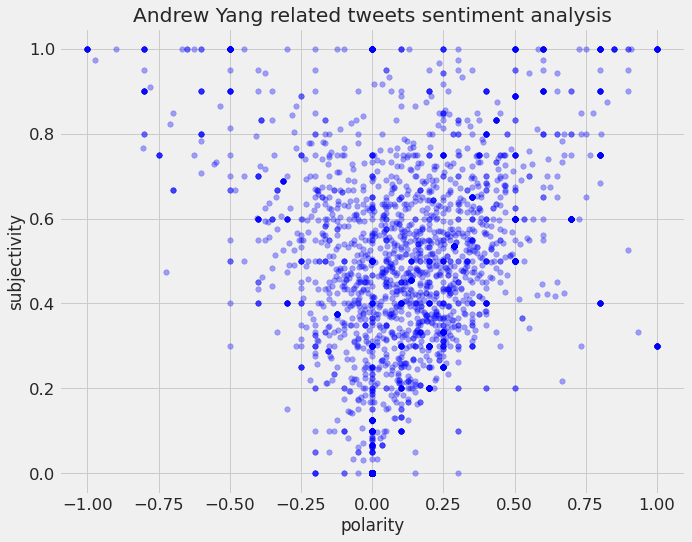

In [839]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
for i in range(len(cleanedtext_df)):
    plt.scatter(cleanedtext_df['polarity'][i],cleanedtext_df['subjectivity'][i],color='Blue',alpha=0.35,s=30)
plt.xlabel('polarity')
plt.ylabel('subjectivity')
plt.title('Andrew Yang related tweets sentiment analysis')
plt.savefig("sentiment.png")
plt.show()


In [694]:
ben_before=df.loc[(df['time']>'2019-03-31')&(df['time']<'2019-04-08')].index
ben_after=df.loc[(df['time']>'2019-04-06')&(df['time']<'2019-04-15')].index
drop_before=df.loc[(df['time']>'2020-01-31')&(df['time']<'2020-02-07')].index
drop_after=df.loc[(df['time']>'2020-02-10')&(df['time']<'2020-02-17')].index
dnc_before=df.loc[(df['time']>'2020-08-05')&(df['time']<'2020-08-13')].index
dnc_after=df.loc[(df['time']>'2020-08-12')].index

Text(0.5, 1.0, 'Before and after Ben Shapiro')

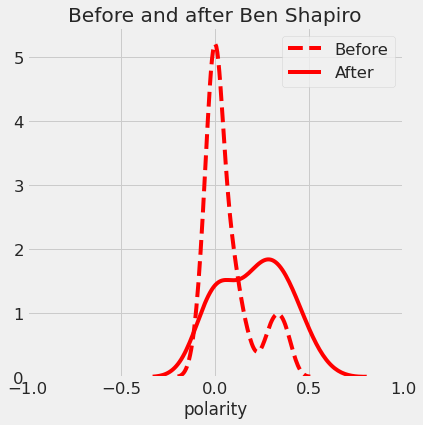

In [703]:
ax1 = sns.distplot(cleanedtext_df['polarity'][ben_before[0]:ben_before[-1]], bins=15, hist = False, label = 'Before', color ='red',  kde_kws={'linestyle':'--'})
ax2 = sns.distplot(cleanedtext_df['polarity'][ben_after[0]:ben_after[-1]], bins=15, hist = False, label = 'After', color ='red')

ax1.set(xlim=(-1,1))

ax1.set_title('Before and after Ben Shapiro')

Text(0.5, 1.0, 'Before and after drop out')

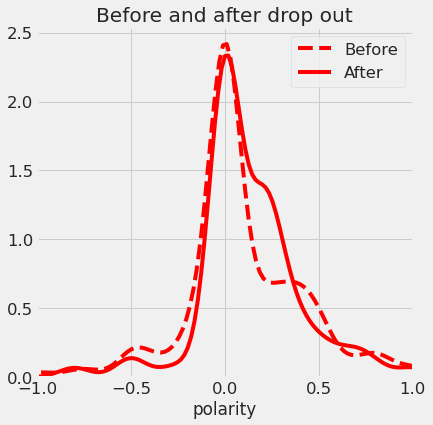

In [840]:
ax3 = sns.distplot(cleanedtext_df['polarity'][drop_before[0]:drop_before[-1]], bins=15, hist = False, label = 'Before', color ='red',  kde_kws={'linestyle':'--'})
ax4 = sns.distplot(cleanedtext_df['polarity'][drop_after[0]:drop_after[-1]], bins=15, hist = False, label = 'After', color ='red')
ax3.set(xlim=(-1,1))
ax3.set_title('Before and after drop out')

Text(0.5, 1.0, 'Before and after DNC announcement')

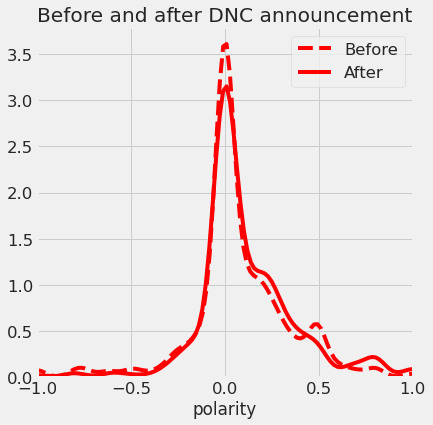

In [841]:
ax5 = sns.distplot(cleanedtext_df['polarity'][dnc_before[0]:dnc_before[-1]], bins=15, hist = False, label = 'Before', color ='red',  kde_kws={'linestyle':'--'})
ax6 = sns.distplot(cleanedtext_df['polarity'][dnc_after[0]:dnc_after[-1]], bins=15, hist = False, label = 'After', color ='red')
ax5.set(xlim=(-1,1))
ax5.set_title('Before and after DNC announcement')

In [711]:
df['time_month'] = pd.to_datetime(df['time']).dt.to_period('M')

In [ ]:
df.sort_values('time_month')

Text(0.5, 1.0, 'Andrew Yang related tweets per month')

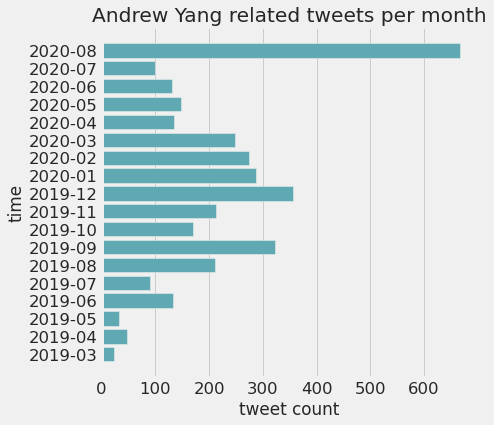

In [836]:
ax =sns.countplot(y="time_month", data=df,orient='v',color='#52b4c1')
monthlabel=df['time_month'].unique()
ax.margins(0.05)
ax.set_ylabel('time')
ax.set_xlabel('tweet count')
ax.set_title('Andrew Yang related tweets per month')


### Word cloud

In [ ]:
az_mask = np.array(Image.open("az.jpg"))
long_string = ','.join(wordcloudtext)


wordcloud_az = WordCloud(stopwords=stop_words2, background_color="white", contour_width=3, contour_color='#990033', max_words=400, mask=az_mask).generate(long_string)

# create coloring from image
image_colors = ImageColorGenerator(az_mask)
plt.figure(figsize=[8,8])
plt.imshow(wordcloud_az, interpolation="bilinear")
plt.axis("off")

In [785]:
flag_mask = np.array(Image.open("flag.png"))
image_colors = ImageColorGenerator(flag_mask)

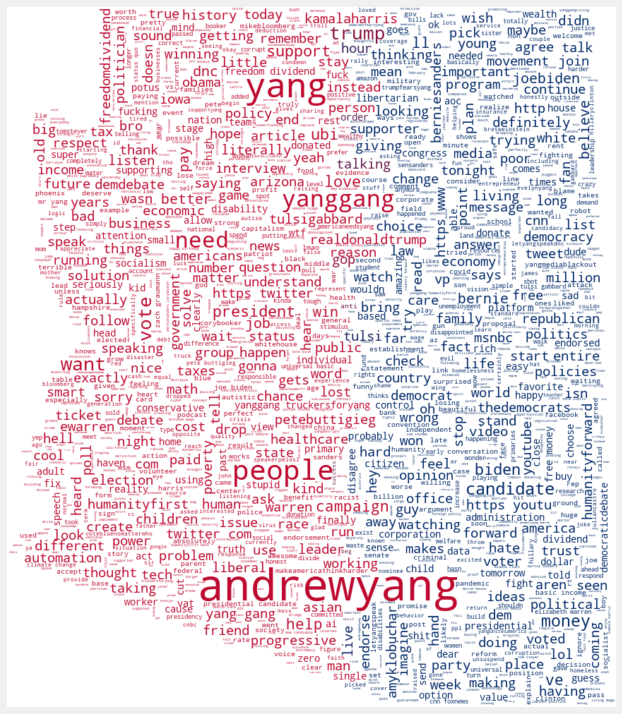

In [798]:
az_mask = np.array(Image.open("az.jpg"))
long_string = ','.join(wordcloudtext)

flag_mask = np.array(Image.open("flag.png"))
image_colors = ImageColorGenerator(flag_mask)

wordcloud_az = WordCloud(stopwords=stop_words2, background_color="white", max_words=1500, mask=az_mask).generate(long_string)


# create coloring from image
#image_colors = ImageColorGenerator(az_mask)

fig, ax = plt.subplots(figsize=(12,12))

plt.imshow(wordcloud_az.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
fig.savefig('wordcloud.png')

In [306]:
plt.rcParams['figure.figsize'] = [6,6]
sns.set_style("whitegrid")
sns.set_context("talk")

### K means

In [279]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

For n_clusters = 2 The average silhouette_score is : 0.19121811424109142
For n_clusters = 3 The average silhouette_score is : 0.19500775283814034
For n_clusters = 4 The average silhouette_score is : 0.20642702936704485
For n_clusters = 5 The average silhouette_score is : 0.20985450229428096
For n_clusters = 6 The average silhouette_score is : 0.21208340202283085
For n_clusters = 7 The average silhouette_score is : 0.21831079317273105
For n_clusters = 8 The average silhouette_score is : 0.23157605680269677
For n_clusters = 9 The average silhouette_score is : 0.2357305313895555
For n_clusters = 10 The average silhouette_score is : 0.2447728045626413
For n_clusters = 11 The average silhouette_score is : 0.2495652641549732
For n_clusters = 12 The average silhouette_score is : 0.25350552541382676
For n_clusters = 13 The average silhouette_score is : 0.2612116144369585
For n_clusters = 14 The average silhouette_score is : 0.26473418572658053
For n_clusters = 15 The average silhouette_score i

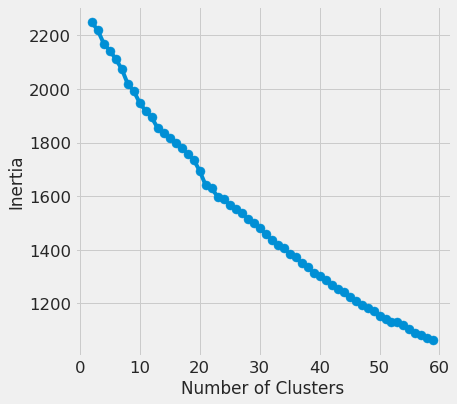

In [390]:
#elbow and silhouette method to find the optimal number of clusters

inertia = []
list_num_clusters = list(range(2,60))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters,random_state=10)
    km.fit(doc_word)
    clusters= km.fit_predict(doc_word)
    inertia.append(km.inertia_)
    silhouette_avg = silhouette_score(doc_word,clusters)
    print("For n_clusters =", num_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

### PCA and TSNE for visualization

In [321]:
pca = PCA(n_components=2)
pca.fit(doc_topic)
pcafeatures = pca.transform(doc_topic)

In [322]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [620]:
tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=10)

In [621]:
tsne_data = tsne_model.fit_transform(doc_topic)

In [622]:
tsne_data=np.vstack((tsne_data.T,topics)).T


In [625]:
tsne_df=pd.DataFrame(data=tsne_data,columns=("dimension 1","dimension 2","label"))

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


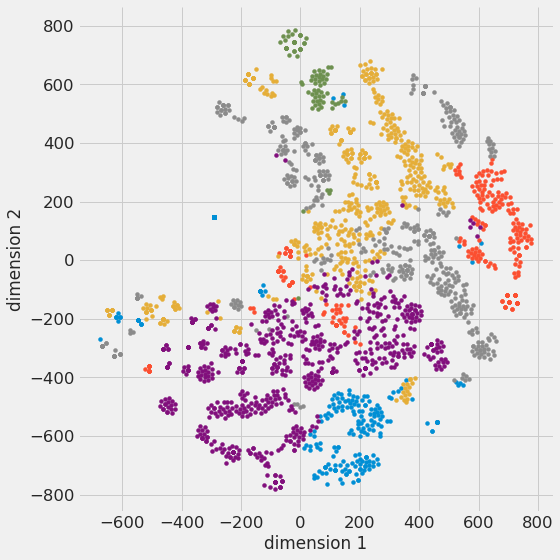

In [875]:
sns.FacetGrid(tsne_df,hue='label',size=8).map(plt.scatter,"dimension 1","dimension 2",s=15)
    
plt.show()

### Multidimensional scaling for visualization

In [369]:
mds = MDS(n_components=2, metric=True, dissimilarity="precomputed", random_state=10, 
              n_init=4, max_iter=1000, verbose=10,n_jobs=4)

In [370]:
pos=mds.fit_transform(1 - cosine_similarity(doc_word))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  7.4min remaining:  7.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.4min finished


In [371]:
xs, ys = pos[:, 0], pos[:, 1]

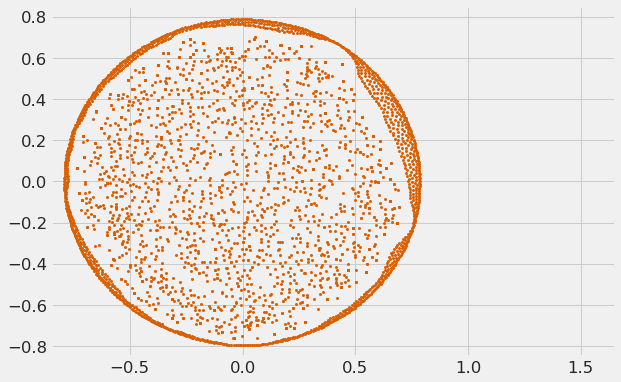

In [397]:
fig, ax = plt.subplots(figsize=(9, 6))
#fig, ax = plt.subplots(figsize=(6,6))
ax.margins(0.05) # Add 5% padding to the autoscaling
ax.plot(xs, ys, marker='o', linestyle='', ms=3, color='#d95f02', alpha=1.0, mec="none" ) 
ax.set_aspect('auto')
ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
ax.set_xlim(-0.85,1.65)
ax.set_ylim(-0.85,0.85)

plt.show()
fig.savefig('mds_tweet_space.png', dpi=200)


In [828]:
topics=[np.argmax(i) for i in doc_topic]
df_nmf= pd.DataFrame(dict(x=xs, y=ys, label=topics)) 
groups_nmf= df_nmf.groupby('label')

In [882]:
df_nmf.groupby('label').count()

,x,y
label,,
0,1496,1496
1,242,242
2,445,445
3,97,97
4,437,437
5,868,868


In [829]:
colors= ['Purple','Blue','Red','Black','Green','Orange','Magenta']

In [830]:
topic_colors ={ic: colors[ind] for ind,ic in enumerate(range(6))}

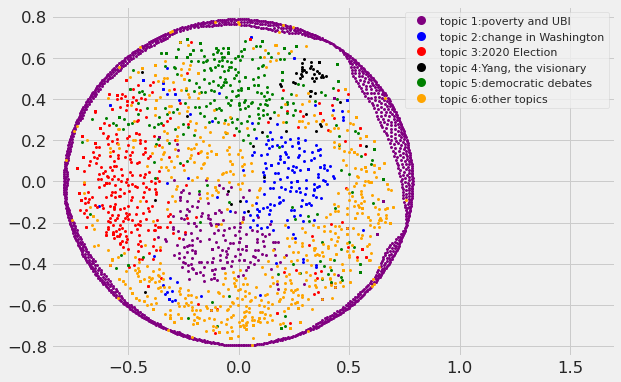

In [874]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.margins(0.05) # Add 5% padding to the autoscaling
ind=0

for topic, group in groups_nmf:

    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, alpha=1.0, 
                label=f'topic {topics_listed[ind][0]}:{topics_listed[ind][1]}', color=topic_colors[topic], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
    ax.set_xlim(-0.85,1.7)
    ax.set_ylim(-0.85,0.85)
    ind+=1
ax.legend(markerscale=3,loc=1,prop={'size': 11})

fig.savefig('mds.png')